## Random Forest & MultiOutputRegressor

### Model: m2_04, 30 layer DGX version

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import glob
import copy
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf
from pyhdf.SD import SD, SDC
import matplotlib.pyplot as plt

In [2]:
libdir = '/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from analysis_lib import mod06_proc_sds
from analysis_lib import _gen_patches

In [3]:
# model directory path
modeldir = "/project2/foster/clouds/model/m2_04_global_2000_2018_band28_29_31"
step = 100000 # DO NOT CHANGE so far

In [4]:
encoder_def = modeldir+'/encoder.json'
encoder_weight = modeldir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


------------
#### load data

MOD02-dimension reduced data
#### train
file:clouds_patches_2011302.1950_3.npz  
dir: /home/tkurihana/scratch-midway2/anl/output_holdouts/80k/group0/

In [7]:
npz_dir  = '/home/tkurihana/scratch-midway2/anl/output_clouds_feature_2000_2018_7'
npzfname = 'clouds_patches_2011302.1950_0.npz'

data_array = np.load(npz_dir+'/'+npzfname)

In [8]:
[ i for i in data_array.keys()]

['encs_mean', 'clouds_xy']

In [9]:
encs_mean = data_array['encs_mean']
clouds_xy = data_array['clouds_xy']

In [10]:
encs_mean.shape

(118, 1024)

MOD06 data

In [16]:
! wget https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD06_L2/2011/302/MOD06_L2.A2011302.1950.061.2017327214802.hdf

--2019-07-10 11:19:34--  https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD06_L2/2011/302/MOD06_L2.A2011302.1950.061.2017327214802.hdf
Resolving ladsweb.modaps.eosdis.nasa.gov (ladsweb.modaps.eosdis.nasa.gov)... 198.118.194.40, 2001:4d0:241a:40c0::40
Connecting to ladsweb.modaps.eosdis.nasa.gov (ladsweb.modaps.eosdis.nasa.gov)|198.118.194.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123797060 (118M) [application/x-hdf]
Saving to: ‘MOD06_L2.A2011302.1950.061.2017327214802.hdf’

100%[======================================>] 123,797,060 40.9MB/s   in 2.9s   

2019-07-10 11:19:38 (40.9 MB/s) - ‘MOD06_L2.A2011302.1950.061.2017327214802.hdf’ saved [123797060/123797060]



In [11]:
#m6_dir = '/home/tkurihana/scratch-midway2/data/MOD06/clustering_valids/'
#m6_bname = 'MOD06_L2.A2011302.1950'

m6_file = glob.glob(
        './MOD06_L2.A2011302.1950.061.2017327214802.hdf'
)[0]
#        m6_dir+'/'+m6_bname+'*.hdf'

In [12]:
m6_hdf = SD(m6_file, SDC.READ)

In [23]:
m6_hdf.datasets()

{'Latitude': (('Cell_Along_Swath_5km:mod06', 'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  5,
  0),
 'Longitude': (('Cell_Along_Swath_5km:mod06', 'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  5,
  1),
 'Scan_Start_Time': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  6,
  2),
 'Solar_Zenith': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  3),
 'Solar_Zenith_Day': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  4),
 'Solar_Zenith_Night': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  5),
 'Solar_Azimuth': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  6),
 'Solar_Azimuth_Day': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  7),
 'Solar_Azimuth_Night': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  8),


In [13]:
# resolution should be 1km
cot_sds = m6_hdf.select("Cloud_Optical_Thickness")
cwp_sds = m6_hdf.select("Cloud_Water_Path")
cpi_sds = m6_hdf.select("Cloud_Phase_Infrared_1km")
ctp_sds = m6_hdf.select("cloud_top_pressure_1km")

In [14]:
cot_array = mod06_proc_sds(cot_sds, 'Cloud_Optical_Thickness')
cwp_array = mod06_proc_sds(cwp_sds, 'Cloud_Water_Path')
cpi_array = mod06_proc_sds(cpi_sds, 'Cloud_Phase_Infrared_1km')
ctp_array = mod06_proc_sds(ctp_sds, 'cloud_top_pressure_1km')

/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs/analysis_lib.py:348: RuntimeWarning: invalid value encountered in greater
  err_idx = np.where(array > 100.0) # optical thickness range[0,100] no unit


Check for plotting

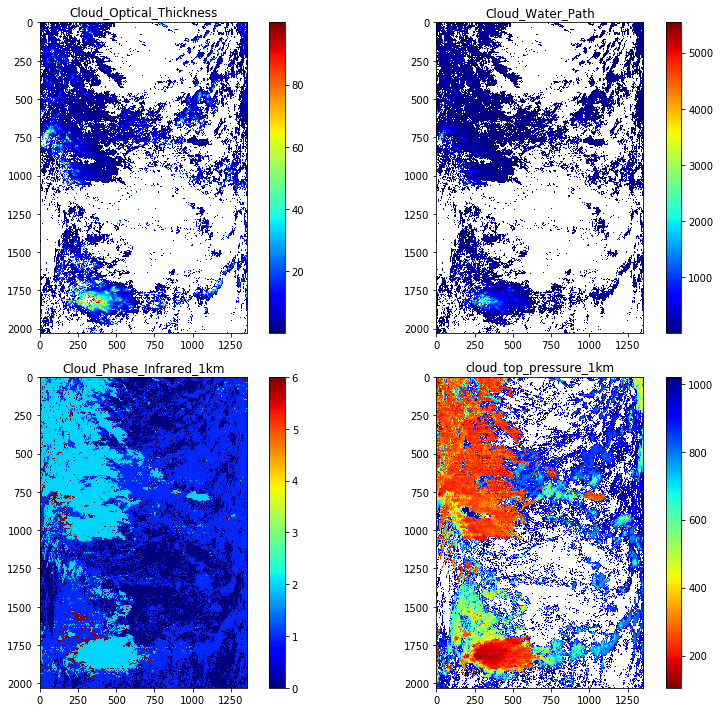

In [30]:
mod06_img = np.asarray([cot_array, cwp_array, cpi_array, ctp_array])

fig = plt.figure(figsize=(12,10))
vname_list = [
    "Cloud_Optical_Thickness",
    "Cloud_Water_Path",
    "Cloud_Phase_Infrared_1km",
    "cloud_top_pressure_1km",
]
for idx , i in enumerate(mod06_img):
    ax = plt.subplot(2,2,idx+1)
    if not  vname_list[idx] == 'cloud_top_pressure_1km':
        plt.imshow(i, cmap='jet')
    else:
         plt.imshow(i, cmap='jet_r')
    plt.colorbar()
    ax.set_title("%s" % vname_list[idx])
fig.tight_layout()
plt.show()

Reconstruct mod02 image

In [15]:
mod02_patches = np.zeros((15,10))
mod02_patches.astype(float)
mod02_patches[:,:] = np.nan
for i in clouds_xy:
    ii,jj = i
    mod02_patches[ii,jj] = 1

Make patches for MOD06

In [16]:
# 
nx, ny = cot_array.shape
d_list = [
    cot_array.reshape(nx,ny,1),
    cwp_array.reshape(nx,ny,1),
    cpi_array.reshape(nx,ny,1),
    ctp_array.reshape(nx,ny,1),
]

#
mod06_img = np.concatenate(d_list, axis=2)

In [17]:
mod06_patches = _gen_patches(mod06_img, normalization=False, flag_nan=True)

In [18]:
mod06_patches.shape

(15, 10, 128, 128, 4)

Get mean value of patches & get mode of phase-infreard

In [19]:
mod06_patches_mean = np.nanmean(mod06_patches, axis=(2,3))

In [20]:
prep_phase = copy.deepcopy(mod06_patches[:,:,:,:,2])
_x, _y = mod06_patches.shape[:2]
phase_mode = np.zeros((_x,_y))
for i in range(_x):
    for j in range(_y):
        phase, _= sc.stats.mode(prep_phase[i,j].ravel(), nan_policy='omit')
        phase_mode[i,j] = phase

Replace nan

In [21]:
cpi_modes = np.zeros((_x,_y)).astype(np.float64)
cpi_modes[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy):
    cpi_modes[x,y] = phase_mode[x,y]

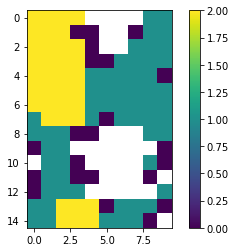

In [50]:
plt.imshow(cpi_modes)
plt.colorbar()

Finally join cpi_mode to mod06 mean array

In [22]:
mod06_patches_mean[:,:,2] = cpi_modes

In [23]:
mod06_patches_mean.shape

(15, 10, 4)

##### Check mod02 patch and mod06 patch

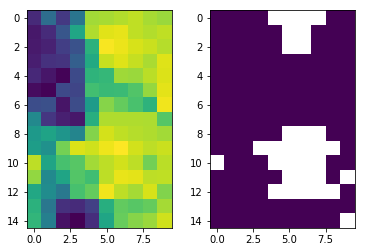

In [27]:
fig = plt.figure()
ax = plt.subplot(1,2,1)
plt.imshow(mod06_patches_mean[:,:,3])
ax = plt.subplot(1,2,2)
plt.imshow(mod02_patches)
plt.show()

##### mod02 + mod06  (only processed mod06 patches where there are valid mod02 patches)

In [24]:
mod06_patches_valid = np.zeros((mod06_patches_mean.shape))
mod06_patches_valid.astype(float)
mod06_patches_valid[:,:] = np.nan

for i in clouds_xy:
    ii,jj = i
    mod06_patches_valid[ii,jj] = mod06_patches_mean[ii,jj]

In [25]:
mod06_patches_valid.shape

(15, 10, 4)

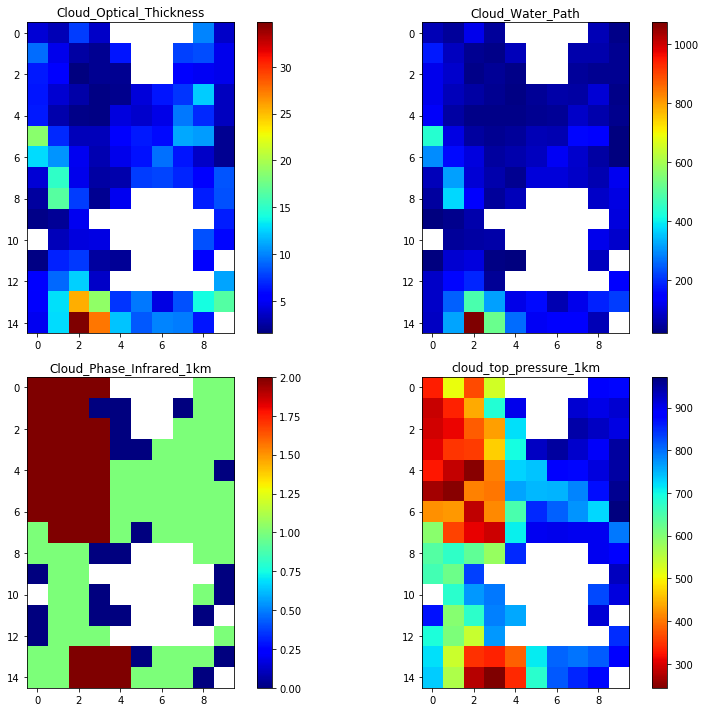

In [101]:
fig = plt.figure(figsize=(12,10))
vname_list = [
    "Cloud_Optical_Thickness",
    "Cloud_Water_Path",
    "Cloud_Phase_Infrared_1km",
    "cloud_top_pressure_1km",
]
for idx in range(mod06_patches_valid.shape[-1]):
    ax = plt.subplot(2,2,idx+1)
    if not  vname_list[idx] == 'cloud_top_pressure_1km':
        plt.imshow(mod06_patches_valid[:,:,idx], cmap='jet')
    else:
         plt.imshow(mod06_patches_valid[:,:,idx], cmap='jet_r')
    plt.colorbar()
    ax.set_title("%s" % vname_list[idx])
fig.tight_layout()
plt.show()

In [31]:
mod06_patches_valid.shape, encs_mean.shape

((15, 10, 4), (118, 128))

Make mod06_patches_valid to 1d - 118 entries array

In [26]:
tmp = mod06_patches_valid.reshape(15*10,4)
clist = []
for i in tmp:
    if not np.isnan(i).all():
        clist.append(i)

In [27]:
encs_labels = np.asarray(clist)
encs_labels.shape

(118, 4)

-----------------------
### Build regression model

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [29]:
# set model
max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))

In [30]:
regr_multirf.fit(encs_mean, encs_labels)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
           n_jobs=1)

-------------------
### Test
dir:/home/tkurihana/scratch-midway2/anl/output_holdouts/80k/group0
fname:/clouds_patches_2009044.1800_0.npz

In [31]:
npz_dir  = '/home/tkurihana/scratch-midway2/anl/output_clouds_feature_2000_2018_7'
npzfname = 'clouds_patches_2009044.1800_0.npz'

data_array = np.load(npz_dir+'/'+npzfname)

In [32]:
encs_mean_test = data_array['encs_mean']
clouds_xy_test = data_array['clouds_xy']

In [33]:
m6_dir = '/home/tkurihana/scratch-midway2/data/MOD06/clustering_valids/'
m6_bname = '2009044.1800'

m6_file_test = glob.glob(
        m6_dir+'/*'+m6_bname+'*.hdf'
)[0]

In [34]:
m6_file_test

'/home/tkurihana/scratch-midway2/data/MOD06/clustering_valids/MOD06_L2.A2009044.1800.061.2017297225903.hdf'

In [35]:
m6_hdf_test = SD(m6_file_test, SDC.READ)

In [36]:
# resolution should be 1km
cot_sds_test = m6_hdf_test.select("Cloud_Optical_Thickness")
cwp_sds_test = m6_hdf_test.select("Cloud_Water_Path")
cpi_sds_test = m6_hdf_test.select("Cloud_Phase_Infrared_1km")
ctp_sds_test = m6_hdf_test.select("cloud_top_pressure_1km")

In [37]:
cot_array_test = mod06_proc_sds(cot_sds_test, 'Cloud_Optical_Thickness')
cwp_array_test = mod06_proc_sds(cwp_sds_test, 'Cloud_Water_Path')
cpi_array_test = mod06_proc_sds(cpi_sds_test, 'Cloud_Phase_Infrared_1km')
ctp_array_test = mod06_proc_sds(ctp_sds_test, 'cloud_top_pressure_1km')

/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs/analysis_lib.py:348: RuntimeWarning: invalid value encountered in greater
  err_idx = np.where(array > 100.0) # optical thickness range[0,100] no unit


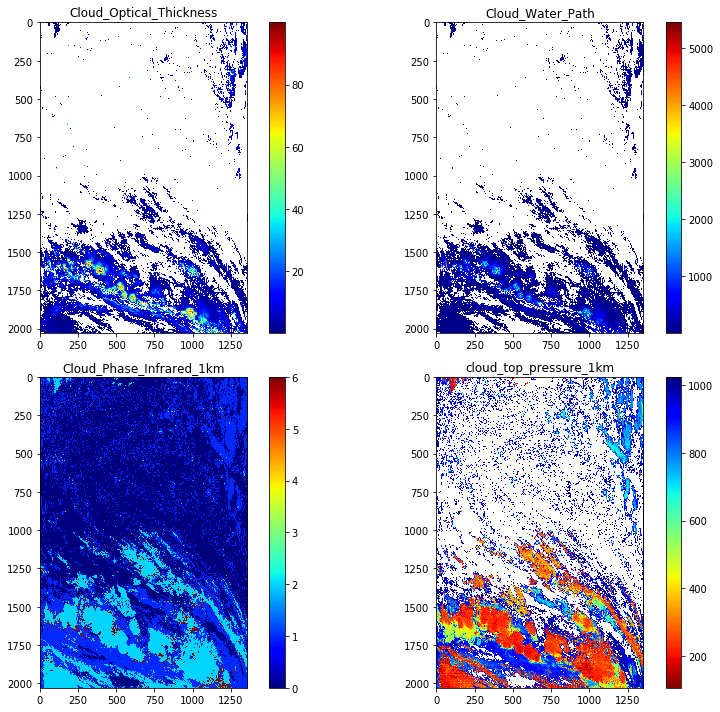

In [55]:
_mod06_img = np.asarray([
    cot_array_test, cwp_array_test, cpi_array_test, ctp_array_test
])

fig = plt.figure(figsize=(12,10))
vname_list = [
    "Cloud_Optical_Thickness",
    "Cloud_Water_Path",
    "Cloud_Phase_Infrared_1km",
    "cloud_top_pressure_1km",
]
for idx , i in enumerate(_mod06_img):
    ax = plt.subplot(2,2,idx+1)
    if not  vname_list[idx] == 'cloud_top_pressure_1km':
        plt.imshow(i, cmap='jet')
    else:
         plt.imshow(i, cmap='jet_r')
    plt.colorbar()
    ax.set_title("%s" % vname_list[idx])
fig.tight_layout()
plt.show()

In [38]:
# Make patches for MOD06 test data 
nx, ny = cot_array_test.shape
_d_list = [
    cot_array_test.reshape(nx,ny,1),
    cwp_array_test.reshape(nx,ny,1),
    cpi_array_test.reshape(nx,ny,1),
    ctp_array_test.reshape(nx,ny,1),
]

#
mod06_img_test = np.concatenate(_d_list, axis=2)

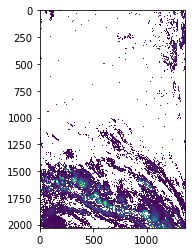

In [75]:
plt.imshow(cot_array_test)

In [39]:
mod06_patches_test = _gen_patches(mod06_img_test, normalization=False, flag_nan=True)

In [40]:
mod06_patches_mean_test = np.nanmean(mod06_patches_test, axis=(2,3))

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [41]:
mod06_patches_mean_test.shape

(15, 10, 4)

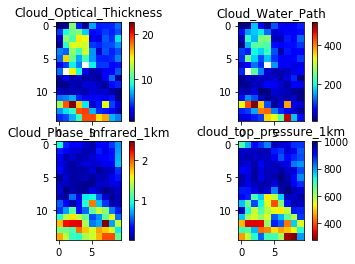

In [82]:
for idx in range(mod06_patches_mean_test.shape[-1]):
    ax = plt.subplot(2,2,idx+1)
    if not  vname_list[idx] == 'cloud_top_pressure_1km':
        plt.imshow(mod06_patches_mean_test[:,:,idx], cmap='jet')
    else:
         plt.imshow(mod06_patches_mean_test[:,:,idx], cmap='jet_r')
    plt.colorbar()
    ax.set_title("%s" % vname_list[idx])
fig.tight_layout()
plt.show()

In [42]:
prep_phase_test = copy.deepcopy(mod06_patches_test[:,:,:,:,2])
_x, _y = mod06_patches_test.shape[:2]
phase_mode_test = np.zeros((_x,_y))
for i in range(_x):
    for j in range(_y):
        phase, _= sc.stats.mode(prep_phase_test[i,j].ravel(), nan_policy='omit')
        phase_mode_test[i,j] = phase

In [43]:
cpi_modes_test = np.zeros((_x,_y)).astype(np.float64)
cpi_modes_test[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_test):
    cpi_modes_test[x,y] = phase_mode_test[x,y]

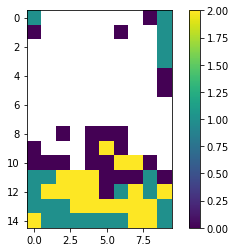

In [85]:
plt.imshow(cpi_modes_test)
plt.colorbar()

Finally jpin cpi_mode_test to mod06 mean array test

In [44]:
mod06_patches_mean_test[:,:,2] = cpi_modes_test

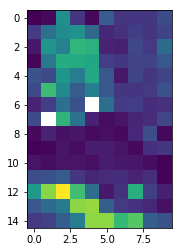

In [45]:
mod06_patches_mean_test.shape
plt.imshow(mod06_patches_mean_test[:,:,0])

In [46]:
mod06_patches_valid_test = np.zeros((mod06_patches_mean_test.shape))
mod06_patches_valid_test.astype(float)
mod06_patches_valid_test[:,:] = np.nan

for i in clouds_xy_test:
    ii,jj = i
    mod06_patches_valid_test[ii,jj] = mod06_patches_mean_test[ii,jj]

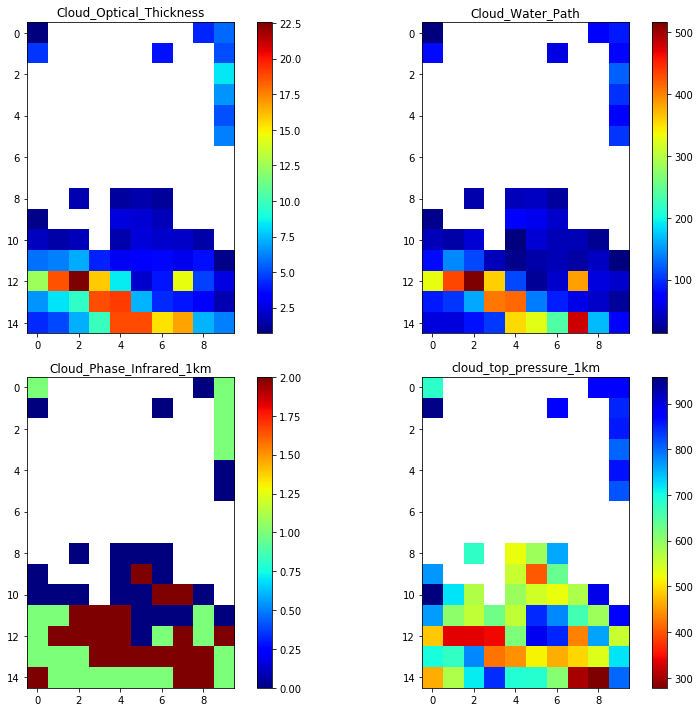

In [47]:
## check by plotting
fig = plt.figure(figsize=(12,10))
vname_list = [
    "Cloud_Optical_Thickness",
    "Cloud_Water_Path",
    "Cloud_Phase_Infrared_1km",
    "cloud_top_pressure_1km",
]
for idx in range(mod06_patches_valid_test.shape[-1]):
    ax = plt.subplot(2,2,idx+1)
    if not  vname_list[idx] == 'cloud_top_pressure_1km':
        plt.imshow(mod06_patches_valid_test[:,:,idx], cmap='jet')
    else:
         plt.imshow(mod06_patches_valid_test[:,:,idx], cmap='jet_r')
    plt.colorbar()
    ax.set_title("%s" % vname_list[idx])
fig.tight_layout()
plt.show()

Made test data

In [48]:
mod06_patches_valid_test.shape, encs_mean_test.shape

((15, 10, 4), (66, 1024))

In [49]:
tmp = mod06_patches_valid_test.reshape(15*10,4)
_clist = []
for i in tmp:
    if not np.isnan(i).all():
        _clist.append(i)
        
encs_labels_test = np.asarray(_clist)
encs_labels_test.shape

(66, 4)

----------------
### Inference by test data

In [50]:
# Predict on new data
y_multirf = regr_multirf.predict(encs_mean_test)

In [51]:
y_multirf.shape

(66, 4)

In [52]:
test_inf = np.zeros((mod06_patches_mean_test.shape))
test_inf.astype(float)
test_inf[:,:] = np.nan

for idx, i in enumerate(clouds_xy_test):
    ii,jj = i
    test_inf[ii,jj] = y_multirf[idx]

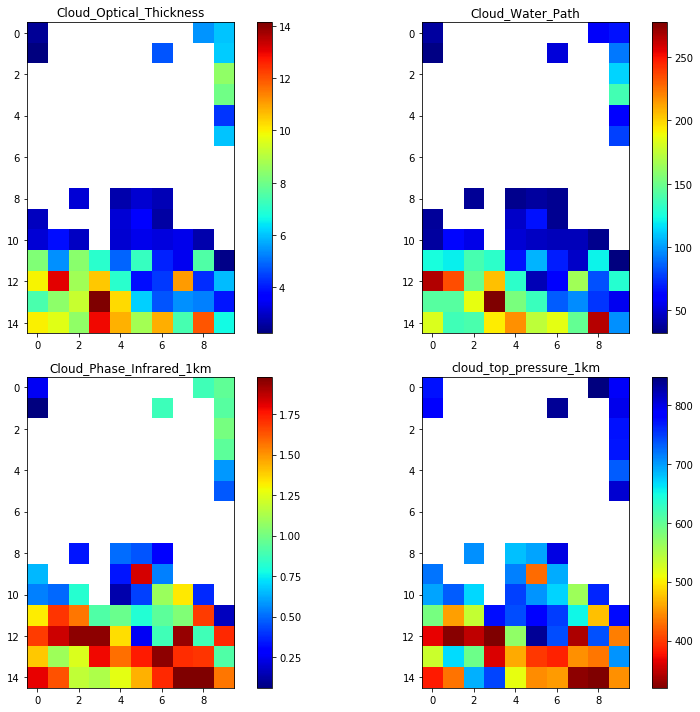

In [53]:
## check by plotting
fig = plt.figure(figsize=(12,10))
vname_list = [
    "Cloud_Optical_Thickness",
    "Cloud_Water_Path",
    "Cloud_Phase_Infrared_1km",
    "cloud_top_pressure_1km",
]
for idx in range(mod06_patches_valid_test.shape[-1]):
    ax = plt.subplot(2,2,idx+1)
    if not  vname_list[idx] == 'cloud_top_pressure_1km':
        plt.imshow(test_inf[:,:,idx], cmap='jet')
    else:
         plt.imshow(test_inf[:,:,idx], cmap='jet_r')
    plt.colorbar()
    ax.set_title("%s" % vname_list[idx])
fig.tight_layout()
plt.show()

Round cloud phase infrared for near integer

In [54]:
test_inf.shape

(15, 10, 4)

In [55]:
rtest_inf = copy.copy(test_inf)  # rounf test inf at phase
nx, ny = rtest_inf.shape[:2]
for i in range(nx):
    for j in range(ny):
        rtest_inf[i,j,2] = round(rtest_inf[i,j,2])

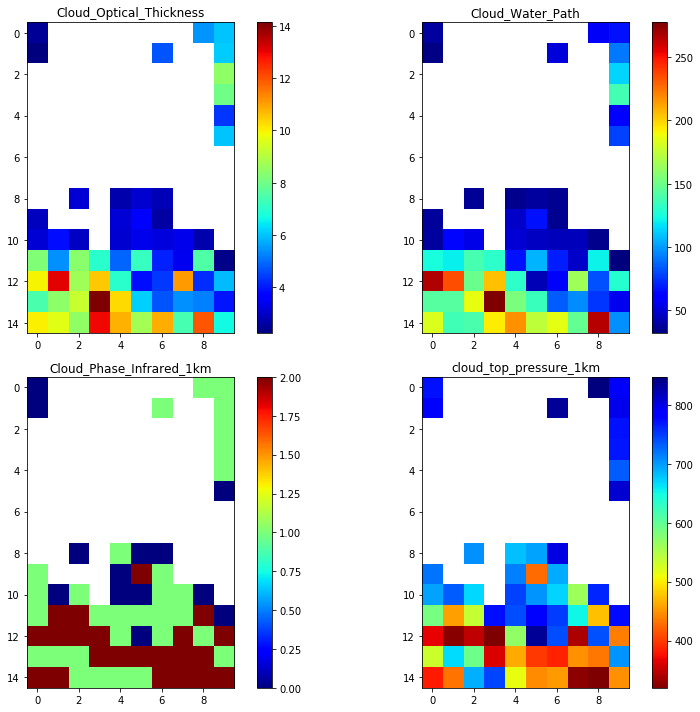

In [56]:
## check by plotting
fig = plt.figure(figsize=(12,10))
vname_list = [
    "Cloud_Optical_Thickness",
    "Cloud_Water_Path",
    "Cloud_Phase_Infrared_1km",
    "cloud_top_pressure_1km",
]
for idx in range(mod06_patches_valid_test.shape[-1]):
    ax = plt.subplot(2,2,idx+1)
    if not  vname_list[idx] == 'cloud_top_pressure_1km':
        plt.imshow(rtest_inf[:,:,idx], cmap='jet')
    else:
         plt.imshow(rtest_inf[:,:,idx], cmap='jet_r')
    plt.colorbar()
    ax.set_title("%s" % vname_list[idx])
fig.tight_layout()
plt.show()

#### Error rate

In [57]:
rmse_list = []
for i in range(4):
    _rmse = []
    for j in range(test_inf.shape[0]):
        for k  in range(test_inf.shape[1]):
            x, y = mod06_patches_valid_test[j,k,i],test_inf[j,k,i]
            if not np.isnan(x):
                if not np.isnan(y):
                    _rmse.append( pow(x-y,2) )
    rmse_list.append(np.sqrt(np.sum(_rmse)/len(_rmse)))

In [113]:
# 8 by 8 by 128 model
rmse_list

[3.2403369131031234, 83.88146104669599, 0.45472269271802046, 86.80346296204293]

In [58]:
# 1 by 1 by 1024
rmse_list

[3.604321302163709, 94.51255847293886, 0.5000848412868045, 115.24784309787775]

Residual

In [59]:
res = mod06_patches_valid_test - test_inf

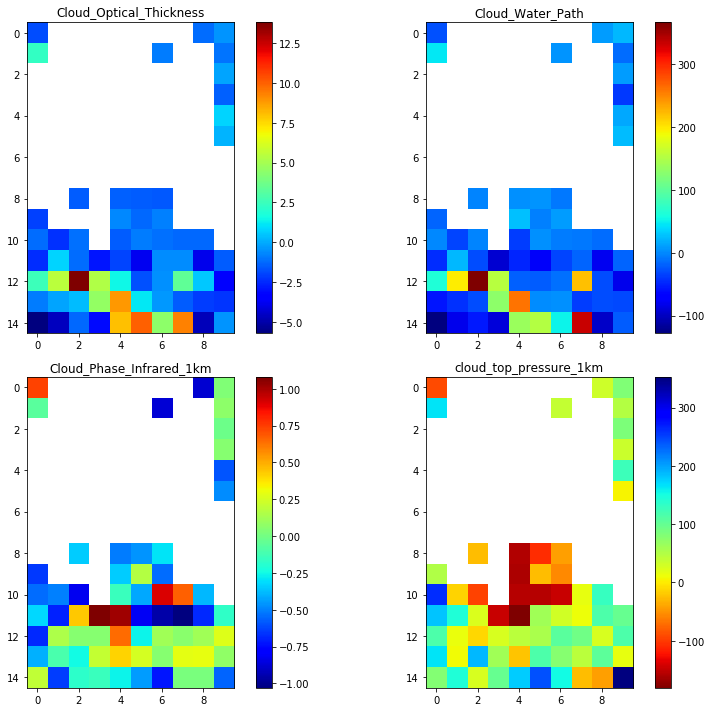

In [60]:
fig = plt.figure(figsize=(12,10))
for idx in range(mod06_patches_valid_test.shape[-1]):
    ax = plt.subplot(2,2,idx+1)
    if not  vname_list[idx] == 'cloud_top_pressure_1km':
        plt.imshow(res[:,:,idx], cmap='jet')
    else:
         plt.imshow(res[:,:,idx], cmap='jet_r')
    plt.colorbar()
    ax.set_title("%s" % vname_list[idx])
fig.tight_layout()
plt.show()

In [5]:
a=1
